 # Car Classification Project

This is a deep learning project about car classfication using the Stanford car dataset. We will be using transfer learning to utilize pretrained deep networks on ImageNet, and fine-tune on our own dataset.

Data source: https://ai.stanford.edu/~jkrause/cars/car_dataset.html


# 1. Data description

The Stanford car dataset contains 16,185 images of 195 classes of cars. The data is split into 8,144 training images and 8,041 testing images, and each class is also split by roughly 50-50. Classes are typically at the level of Make, Model, and Year, eg. 2012 Tesla Model S or 2012 BMW M3 coupe. On average, there are 41.5 images per class in the training set, and 40.5 images in the testing set.

# 2. Setting up environment and loading data

## 2.1 Extract dataset files

In [ ]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy dataset from google drive to colab
!cp ./drive/My\ Drive/Colab\ Notebooks/Car\ Classification/stanford_car_dataset.zip ./

In [ ]:
%%time
# unzip dataset in colab
!mkdir ./stanford_car_dataset
!unzip -q stanford_car_dataset.zip -d ./stanford_car_dataset

CPU times: user 113 ms, sys: 32.2 ms, total: 145 ms
Wall time: 22.1 s


## 2.2 Loading packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


# 3. Modeling

## 3.1 Load and transform data

In [ ]:
dataset_dir = "stanford_car_dataset/car_data/car_data/"

# data transformation, you can try different transformation/ data augmentation here
# note: no data augmentation for test data

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 torchvision.transforms.AutoAugment(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# create datasets
dataset = torchvision.datasets.ImageFolder(root = dataset_dir + "train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root = dataset_dir + "test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle = False, num_workers = 2)

## 3.2 Define model training function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
  losses = []
  accuracies = []
  test_accuracies = []

  # set the model to train mode initially
  model.train()
  for epoch in tqdm.tqdm(range(n_epochs)):
    since = time.time()
    running_loss = 0.0
    running_correct = 0.0
    for i, data in enumerate(trainloader, 0):

      # get the inputs and assign them to cuda
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
            
      # forward + backward + optimize
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
            
      # calculate the loss/acc later
      running_loss += loss.item()
      running_correct += (labels == predicted).sum().item()

    epoch_duration = time.time() - since
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 / 32 * running_correct / len(trainloader)
    print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch + 1, epoch_duration, epoch_loss, epoch_acc))
        
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
        
    # switch the model to eval mode to evaluate on test data
    model.eval()
    test_acc = eval_model(model)
    test_accuracies.append(test_acc)
        
    # re-set the model to train mode after validating
    model.train()
    scheduler.step(test_acc)
    since = time.time()
  print('Finished Training')
  return model, losses, accuracies, test_accuracies

## 3.3 Define model evaluation function

In [ ]:
def eval_model(model):
  correct = 0.0
  total = 0.0
  with torch.no_grad():
    for i, data in enumerate(testloader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = model_ft(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_acc = 100.0 * correct / total
  print('Accuracy of the network on the test images: %d %%' % (test_acc))
  return test_acc

# 4. Implementation using ResNet34

## 4.1 Define model parameters

In [ ]:
#ResNet34:
NUM_CAR_CLASSES = 196

model_ft = models.resnet34(pretrained = True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr = 0.01, momentum = 0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## 4.2 Training

In [ ]:
# ResNet:
model_ft_res, training_losses_res, training_accs_res, test_accs_res = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 51 s, loss: 4.4032, acc: 8.9461


  5%|▌         | 1/20 [01:37<30:52, 97.52s/it]

Accuracy of the network on the test images: 19 %
Epoch 2, duration: 52 s, loss: 2.6674, acc: 32.2059


 10%|█         | 2/20 [03:15<29:20, 97.82s/it]

Accuracy of the network on the test images: 36 %
Epoch 3, duration: 52 s, loss: 1.9118, acc: 48.1127


 15%|█▌        | 3/20 [04:53<27:47, 98.06s/it]

Accuracy of the network on the test images: 46 %
Epoch 4, duration: 53 s, loss: 1.5609, acc: 56.4583


 20%|██        | 4/20 [06:32<26:11, 98.22s/it]

Accuracy of the network on the test images: 52 %
Epoch 5, duration: 52 s, loss: 1.2484, acc: 64.0564


 25%|██▌       | 5/20 [08:10<24:31, 98.10s/it]

Accuracy of the network on the test images: 62 %
Epoch 6, duration: 53 s, loss: 1.0440, acc: 69.0196


 30%|███       | 6/20 [09:49<23:00, 98.58s/it]

Accuracy of the network on the test images: 65 %
Epoch 7, duration: 52 s, loss: 0.5266, acc: 85.2819


 35%|███▌      | 7/20 [11:28<21:20, 98.52s/it]

Accuracy of the network on the test images: 82 %
Epoch 8, duration: 52 s, loss: 0.3901, acc: 89.1422


 40%|████      | 8/20 [13:06<19:40, 98.34s/it]

Accuracy of the network on the test images: 83 %
Epoch 9, duration: 52 s, loss: 0.3349, acc: 90.6495


 45%|████▌     | 9/20 [14:44<18:00, 98.25s/it]

Accuracy of the network on the test images: 84 %
Epoch 10, duration: 52 s, loss: 0.3051, acc: 91.6422


 50%|█████     | 10/20 [16:22<16:23, 98.35s/it]

Accuracy of the network on the test images: 84 %
Epoch 11, duration: 52 s, loss: 0.2824, acc: 92.3162


 55%|█████▌    | 11/20 [18:00<14:44, 98.27s/it]

Accuracy of the network on the test images: 84 %
Epoch 12, duration: 52 s, loss: 0.2560, acc: 93.1618


 60%|██████    | 12/20 [19:39<13:07, 98.39s/it]

Accuracy of the network on the test images: 85 %
Epoch 13, duration: 53 s, loss: 0.2559, acc: 93.5539


 65%|██████▌   | 13/20 [21:18<11:29, 98.49s/it]

Accuracy of the network on the test images: 84 %
Epoch 14, duration: 52 s, loss: 0.2471, acc: 93.5172


 70%|███████   | 14/20 [22:57<09:52, 98.77s/it]

Accuracy of the network on the test images: 85 %
Epoch 15, duration: 53 s, loss: 0.2440, acc: 93.5907


 75%|███████▌  | 15/20 [24:36<08:14, 98.94s/it]

Accuracy of the network on the test images: 85 %
Epoch 16, duration: 52 s, loss: 0.2466, acc: 93.4559


 80%|████████  | 16/20 [26:16<06:36, 99.20s/it]

Accuracy of the network on the test images: 85 %
Epoch 17, duration: 53 s, loss: 0.2402, acc: 93.7990


 85%|████████▌ | 17/20 [27:56<04:58, 99.34s/it]

Accuracy of the network on the test images: 84 %
Epoch 18, duration: 53 s, loss: 0.2449, acc: 93.4069


 90%|█████████ | 18/20 [29:35<03:18, 99.36s/it]

Accuracy of the network on the test images: 85 %
Epoch 19, duration: 53 s, loss: 0.2471, acc: 93.5539


 95%|█████████▌| 19/20 [31:15<01:39, 99.50s/it]

Accuracy of the network on the test images: 85 %
Epoch 20, duration: 52 s, loss: 0.2393, acc: 93.7132


100%|██████████| 20/20 [32:54<00:00, 98.72s/it]

Accuracy of the network on the test images: 84 %
Finished Training


The network reach 90% training accuracy and 85% testing accuracy (peak performace) by epoch 10

Text(0.5, 1.0, 'Test acc')

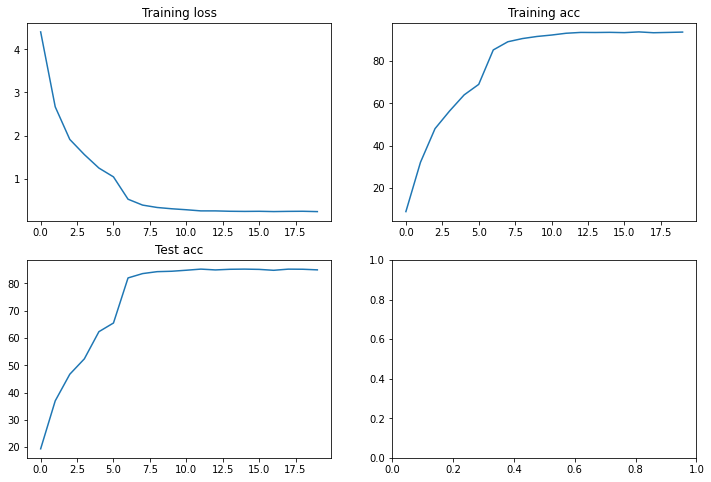

In [ ]:
# plot the stats
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses_res)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs_res)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs_res)
axarr[1, 0].set_title("Test acc")


## 4.3 Evaluate the model on single images

We do this as if we would in real-life production

In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir + "train")

In [ ]:
# define a function to load image and evaluate
def single_img_eval(model_ft, imgdir):
  # switch the model to evaluation mode to make dropout and batch norm work in eval mode
  model_ft.eval()

  # transforms for the input image
  loader = transforms.Compose([transforms.Resize((400, 400)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  image = Image.open(dataset_dir + imgdir)
  image = loader(image).float()
  image = torch.autograd.Variable(image, requires_grad=True)
  image = image.unsqueeze(0)
  image = image.cuda()
  output = model_ft(image)
  conf, predicted = torch.max(output.data, 1)

  display(Image.open(dataset_dir + imgdir))
  print(classes[predicted.item()], "confidence: ", conf.item())

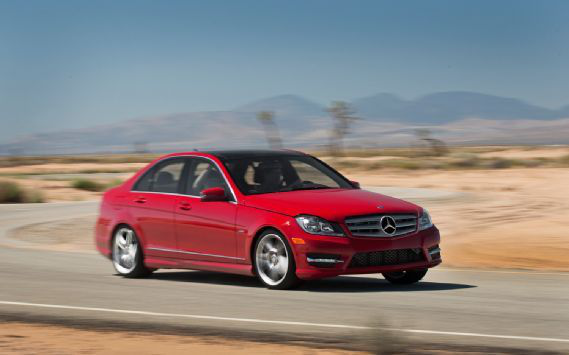

Mercedes-Benz C-Class Sedan 2012 confidence:  8.134016036987305


In [ ]:
single_img_eval(model_ft_res, "test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")

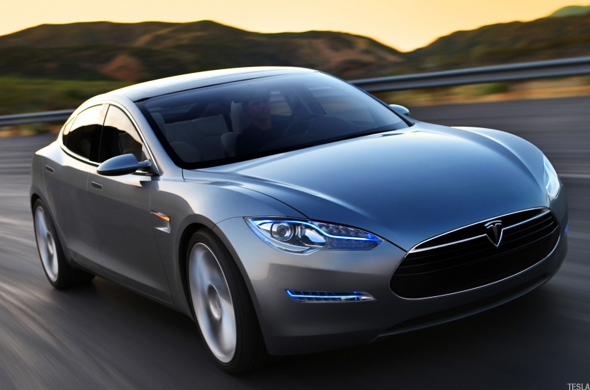

Tesla Model S Sedan 2012 confidence:  8.106595993041992


In [ ]:
single_img_eval(model_ft_res, "test/Tesla Model S Sedan 2012/05224.jpg")

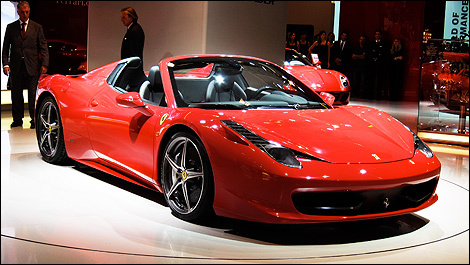

Ferrari 458 Italia Coupe 2012 confidence:  9.701860427856445


In [ ]:
single_img_eval(model_ft_res, "test/Ferrari 458 Italia Convertible 2012/04763.jpg")

Our network adopted from ResNet34 have successfully classified two out of three cars with high confidence. For the third car, the network failed to distinguish a convertible from a coupe of the same type.

## 4.4 Save the model for future use

In [ ]:
torch.save(model_ft_res.state_dict(), 'car_model_resnet.pth')

# 5. Implementation using GoogLeNet

## 5.1 Define model parameters

In [ ]:
# GoogLeNet:
NUM_CAR_CLASSES = 196

model_ft = models.googlenet(pretrained = True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)
model_ft = model_ft.to(device)

optimizer = optim.SGD(model_ft.parameters(), lr = 0.01, momentum = 0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 3, threshold = 0.9)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

## 5.2 Training

In [ ]:
# GoogLeNet:
model_ft_google, training_losses_google, training_accs_google, test_accs_google = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 51 s, loss: 4.8207, acc: 4.8039


  5%|▌         | 1/20 [01:36<30:26, 96.12s/it]

Accuracy of the network on the test images: 17 %
Epoch 2, duration: 51 s, loss: 3.1766, acc: 24.4485


 10%|█         | 2/20 [03:13<28:58, 96.57s/it]

Accuracy of the network on the test images: 42 %
Epoch 3, duration: 52 s, loss: 2.1647, acc: 44.1912


 15%|█▌        | 3/20 [04:51<27:34, 97.34s/it]

Accuracy of the network on the test images: 50 %
Epoch 4, duration: 52 s, loss: 1.5968, acc: 57.4877


 20%|██        | 4/20 [06:28<25:59, 97.50s/it]

Accuracy of the network on the test images: 62 %
Epoch 5, duration: 52 s, loss: 1.2686, acc: 65.5392


 25%|██▌       | 5/20 [08:06<24:24, 97.63s/it]

Accuracy of the network on the test images: 66 %
Epoch 6, duration: 52 s, loss: 1.0338, acc: 71.5441


 30%|███       | 6/20 [09:45<22:49, 97.85s/it]

Accuracy of the network on the test images: 72 %
Epoch 7, duration: 52 s, loss: 0.6800, acc: 81.8260


 35%|███▌      | 7/20 [11:24<21:16, 98.20s/it]

Accuracy of the network on the test images: 82 %
Epoch 8, duration: 52 s, loss: 0.5574, acc: 86.2500


 40%|████      | 8/20 [13:02<19:37, 98.16s/it]

Accuracy of the network on the test images: 83 %
Epoch 9, duration: 53 s, loss: 0.5127, acc: 87.0956


 45%|████▌     | 9/20 [14:41<18:04, 98.63s/it]

Accuracy of the network on the test images: 83 %
Epoch 10, duration: 52 s, loss: 0.4827, acc: 88.1495


 50%|█████     | 10/20 [16:20<16:26, 98.66s/it]

Accuracy of the network on the test images: 84 %
Epoch 11, duration: 52 s, loss: 0.4497, acc: 89.1422


 55%|█████▌    | 11/20 [17:59<14:49, 98.83s/it]

Accuracy of the network on the test images: 84 %
Epoch 12, duration: 52 s, loss: 0.4314, acc: 90.1103


 60%|██████    | 12/20 [19:38<13:09, 98.69s/it]

Accuracy of the network on the test images: 84 %
Epoch 13, duration: 52 s, loss: 0.4206, acc: 90.4534


 65%|██████▌   | 13/20 [21:16<11:30, 98.71s/it]

Accuracy of the network on the test images: 84 %
Epoch 14, duration: 53 s, loss: 0.4200, acc: 89.9265


 70%|███████   | 14/20 [22:56<09:53, 98.93s/it]

Accuracy of the network on the test images: 84 %
Epoch 15, duration: 53 s, loss: 0.4252, acc: 89.8284


 75%|███████▌  | 15/20 [24:35<08:14, 98.96s/it]

Accuracy of the network on the test images: 84 %
Epoch 16, duration: 53 s, loss: 0.4245, acc: 89.9877


 80%|████████  | 16/20 [26:14<06:35, 98.88s/it]

Accuracy of the network on the test images: 84 %
Epoch 17, duration: 52 s, loss: 0.4154, acc: 90.0368


 85%|████████▌ | 17/20 [27:53<04:56, 98.99s/it]

Accuracy of the network on the test images: 84 %
Epoch 18, duration: 53 s, loss: 0.4152, acc: 90.1838


 90%|█████████ | 18/20 [29:32<03:18, 99.05s/it]

Accuracy of the network on the test images: 84 %
Epoch 19, duration: 52 s, loss: 0.4120, acc: 90.3922


 95%|█████████▌| 19/20 [31:11<01:38, 98.97s/it]

Accuracy of the network on the test images: 84 %
Epoch 20, duration: 52 s, loss: 0.4133, acc: 90.1471


100%|██████████| 20/20 [32:49<00:00, 98.48s/it]

Accuracy of the network on the test images: 84 %
Finished Training


Similarly, we observe that the network reached its peak performnce (90% training accuracy and 84% testing accuracy) by epoch 12.

Text(0.5, 1.0, 'Test acc')

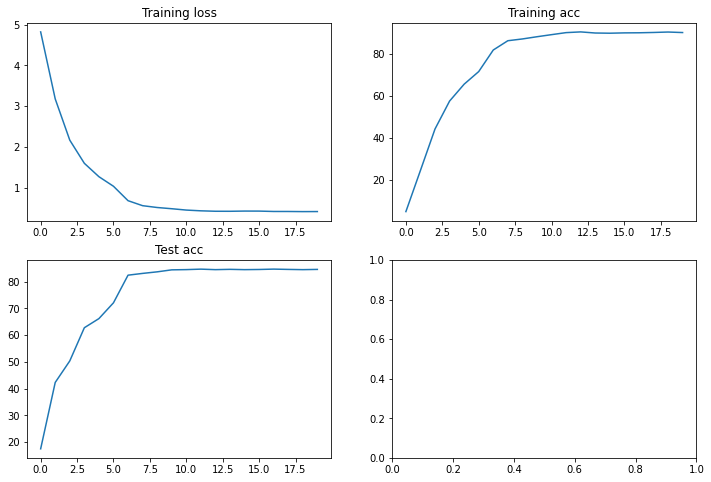

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses_google)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs_google)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs_google)
axarr[1, 0].set_title("Test acc")


## 5.3 Evaluate model on single images

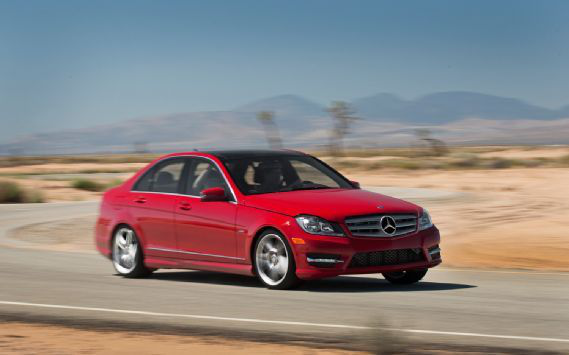

Mercedes-Benz C-Class Sedan 2012 confidence:  5.087674140930176


In [ ]:
single_img_eval(model_ft_google, "test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")

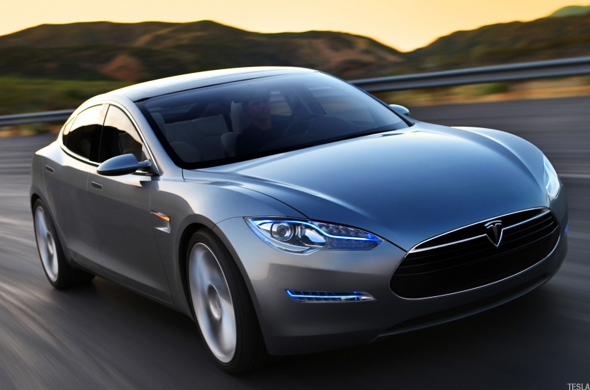

Tesla Model S Sedan 2012 confidence:  5.098053455352783


In [ ]:
single_img_eval(model_ft_google, "test/Tesla Model S Sedan 2012/05224.jpg")

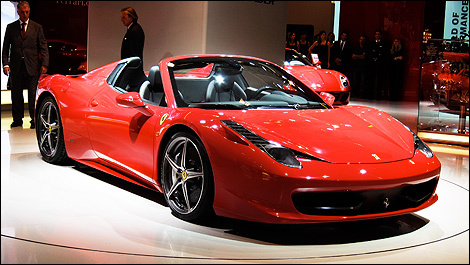

Ferrari 458 Italia Convertible 2012 confidence:  5.621514320373535


In [ ]:
single_img_eval(model_ft_google,  "test/Ferrari 458 Italia Convertible 2012/04763.jpg")

Our network adopted from GoogLeNet did a good job by correctly classifing all three cars, but with lower confidence than results from ResNet34.

## 5.4 Save the model for later use

In [ ]:
torch.save(model_ft_google.state_dict(), 'car_model_googlenet.pth')

# 6. Conclusion

In this project, we implemeneted the 'off-the-shelf' transfer learning technique on pre-trained state-of-the-art ResNet34 and GoogLeNet networks. We adopted these networks by replcing their last fully connected layer with a untrained one, then freeze the deeper layers and train the final layer using our data: the Stanford car data, using stochastic gradient descent. We used adaptive learning rate to optimized the training process. We also used augmentation on training data to avoid overfitting.

Our result was quite gratifying, both adopted networks had high performace: the network from ResNet34 had 93% training accuracy and 85% testing accuracy; the network from GoogLeNet had 90% training accuracy and 84% testing accuracy.

At the end we also evaluated out models using single images to mimic a real-life production scnario, and out model performed well.

# 7. Future Direction

Our next step in transfer learning would be going deeper in the the pre-trained networks: maybe training a few more new layers, or fine-tuning some of the deeper layers. Maybe this can raise the performace to a higher level and solve the problem of convertible vs. coupe.

Also, we would like to use the transfer learning on task other than image classifation, perhaps some natural language processing.